In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install -U ultralytics

## Importa√ß√µes

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Model, load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import h5py
import tensorflow as tf
import cv2
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


## Crregamento dos dados
Nesta c√©lula de c√≥digo, a primeira parte √© respons√°vel por carregar os dados de um arquivo HDF5 utilizando a biblioteca h5py. O arquivo chamado 'combined_data.h5', que est√° armazenado no Google Drive, cont√©m dois conjuntos de dados: X e Y. O conjunto de dados X parece representar as imagens de entrada, enquanto o conjunto Y cont√©m as respectivas m√°scaras de segmenta√ß√£o ou labels correspondentes. Ao abrir o arquivo com h5py.File, os dados s√£o carregados na mem√≥ria nas vari√°veis X_data e Y_data.

## Vizualiza√ß√£o dos dados
Em seguida, um la√ßo for itera sobre as primeiras cinco imagens do conjunto de dados. Dentro desse la√ßo, s√£o criadas figuras com duas subplots para visualiza√ß√£o das imagens. A primeira subplot mostra as imagens do conjunto X_data (que podem ser as imagens originais), enquanto a segunda subplot exibe as imagens correspondentes do conjunto Y_data (provavelmente as m√°scaras ou resultados esperados da segmenta√ß√£o). Cada imagem recebe um t√≠tulo indicando o √≠ndice, e a fun√ß√£o plt.show() √© chamada para exibir as figuras.

## Normaliza√ß√£o
Depois de exibir as imagens, os dados s√£o normalizados. As imagens em X_data e as m√°scaras em Y_data s√£o divididas por 255.0 para que seus valores fiquem dentro do intervalo de 0 a 1. Essa normaliza√ß√£o √© uma pr√°tica comum no processamento de imagens, pois ajuda a estabilizar o treinamento de modelos de machine learning ao garantir que os valores estejam em uma escala adequada.

Por fim, a forma do conjunto Y_data √© impressa com print(Y_data.shape), o que ajuda a verificar se o formato das m√°scaras √© o esperado e se corresponde ao formato das imagens de entrada.

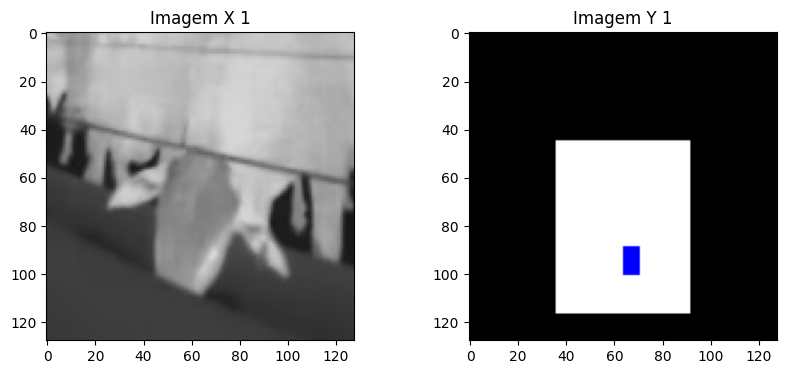

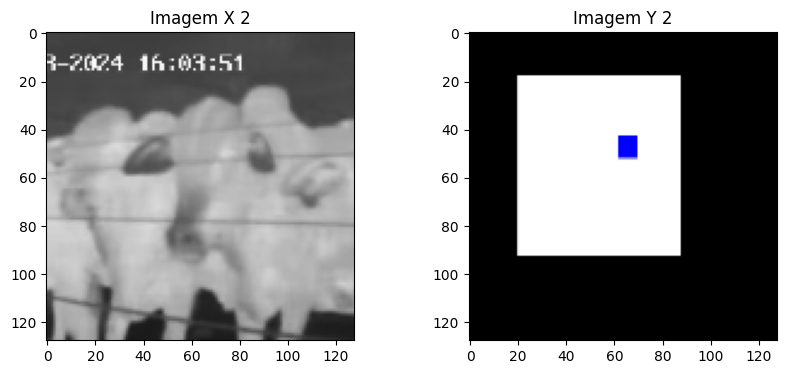

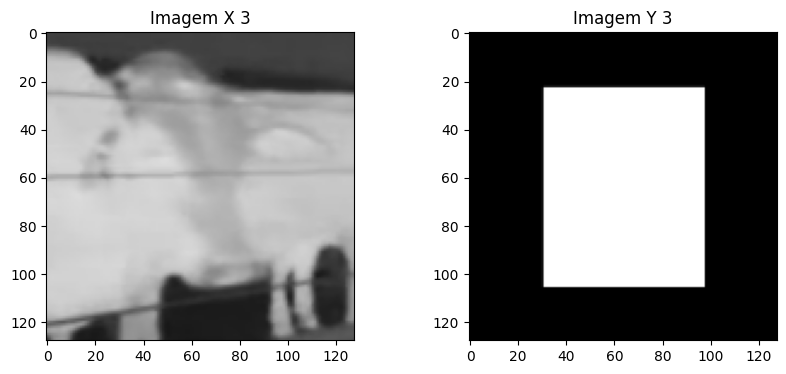

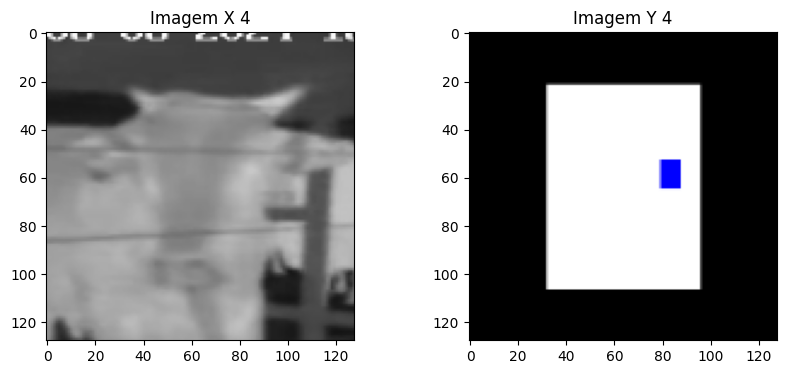

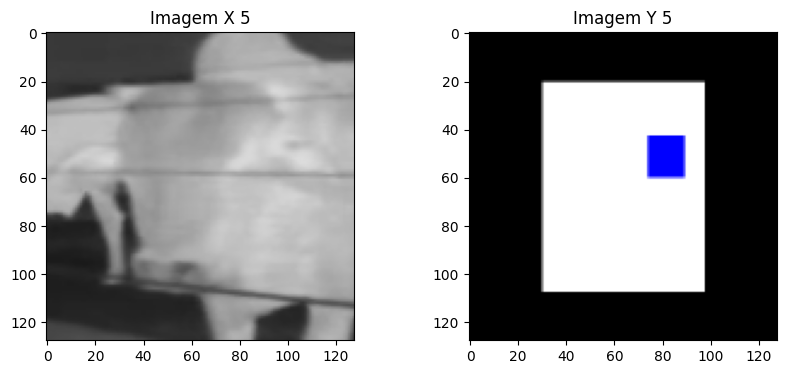

(2420, 128, 128, 3)


In [8]:
with h5py.File('/content/drive/MyDrive/Colab Notebooks/data/combined_data.h5', 'r') as h5f:
    X_data = h5f['X'][:]
    Y_data = h5f['Y'][:]

for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))
    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')
    # Plotando a imagem Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data[i])
    plt.title(f'Imagem Y {i+1}')
    plt.show()

# Normalizando os dados
X_data = X_data / 255.0
Y_data = Y_data / 255.0
print(Y_data.shape)

## Manipula√ß√£o das m√°scaras

Nesta c√©lula, duas fun√ß√µes s√£o definidas para manipular e visualizar as m√°scaras RGB. A fun√ß√£o inspect_mask_channels(mask) verifica os valores √∫nicos dos canais vermelho, verde e azul de uma m√°scara RGB, √∫til para inspecionar se os dados est√£o no formato correto. J√° a fun√ß√£o process_data(mask) converte uma m√°scara RGB em uma m√°scara bin√°ria, identificando a √°rea do olho com base nos valores dos canais RGB (canal azul igual a 1, e vermelho e verde iguais a 0). As m√°scaras processadas s√£o armazenadas em Y_data_processed.

Ap√≥s o processamento, os dados s√£o divididos em treino e valida√ß√£o, com 80% para treino e 20% para valida√ß√£o. Por fim, uma imagem original e sua m√°scara bin√°ria correspondente s√£o exibidas para verificar visualmente o resultado do processamento.

In [9]:

# Fun√ß√£o para inspecionar os valores dos canais RGB na m√°scara
def inspect_mask_channels(mask):
    if mask.ndim == 3:  # M√°scara RGB
        print("Valores do Canal Vermelho (R):", np.unique(mask[:, :, 0]))
        print("Valores do Canal Verde (G):", np.unique(mask[:, :, 1]))
        print("Valores do Canal Azul (B):", np.unique(mask[:, :, 2]))
    else:
        print("A m√°scara n√£o possui 3 canais (RGB).")

# Fun√ß√£o para criar uma m√°scara bin√°ria para o olho a partir de uma m√°scara RGB
def process_data(mask):

    if mask.ndim == 3:
        eye_mask = (mask[:, :, 2] == 1.0) & (mask[:, :, 0] == 0.0) & (mask[:, :, 1] == 0.0)
        eye_mask = eye_mask.astype(np.float32)
    else:
        raise ValueError("A m√°scara fornecida n√£o tem 3 canais (RGB). Verifique o formato da m√°scara.")

    return np.expand_dims(eye_mask, axis=-1)

# Aplicando o pr√©-processamento em todas as m√°scaras no conjunto de dados Y_data
Y_data_processed = np.array([process_data(mask) for mask in Y_data])

# Dividindo em treino e valida√ß√£o
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data_processed, test_size=0.2, random_state=42)


### Compila√ß√£o e Treinamento do Modelo YOLOv8 para Detec√ß√£o de Cabe√ßa de Vaca



**Compila√ß√£o do Modelo**: O YOLOv8, pr√©-treinado no modelo base yolov8s.pt, √© configurado para a tarefa de detec√ß√£o, utilizando o arquivo de dados data.yaml, que cont√©m as anota√ß√µes e a estrutura do conjunto de dados. O modelo √© otimizado com o otimizador Adam ou SGD, e a taxa de aprendizado pode ser ajustada conforme necess√°rio. A fun√ß√£o de perda usada inclui a detec√ß√£o de caixas delimitadoras e a classifica√ß√£o de objetos, adequada para identificar a cabe√ßa de vaca nas imagens.

**Treinamento do Modelo**: O treinamento √© realizado com 25 √©pocas, usando imagens redimensionadas para 128x128 pixels (imgsz=128). O conjunto de dados √© especificado no arquivo data.yaml, que define as classes e os caminhos para as imagens e anota√ß√µes. O progresso do treinamento √© salvo no projeto runs/detect com o nome detect_head_cow. Durante o treinamento, o modelo ajusta suas previs√µes e otimiza suas capacidades de detectar cabe√ßas de vacas nas imagens.

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import xml.etree.ElementTree as ET

# Fun√ß√£o que converte a m√°scara da cabe√ßa em caixa delimitadora no formato YOLO
def mask_to_bbox(mask):
    """Converte uma m√°scara bin√°ria em uma caixa delimitadora no formato YOLO."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not np.any(rows) or not np.any(cols):
        return None

    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]

    x_center = (x_min + x_max) / 2 / mask.shape[1]  # Normalizando
    y_center = (y_min + y_max) / 2 / mask.shape[0]  # Normalizando
    width = (x_max - x_min) / mask.shape[1]  # Normalizando
    height = (y_max - y_min) / mask.shape[0]  # Normalizando

    return [x_center, y_center, width, height]

# Fun√ß√£o para plotar a caixa delimitadora na imagem
def plot_bbox(image, bbox):
    """Plota a imagem e a caixa delimitadora."""
    x_center, y_center, width, height = bbox
    img_height, img_width = image.shape[:2]

    # Convertendo as coordenadas normalizadas para pixels
    x_min = int((x_center - width / 2) * img_width)
    x_max = int((x_center + width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    y_max = int((y_center + height / 2) * img_height)

    # Plotando a imagem e a caixa delimitadora
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                       edgecolor='red', facecolor='none', linewidth=2))
    plt.axis('off')
    plt.show()

def process_images(frame_subfolders, frame_offsets):
    os.makedirs('datasets/images/train', exist_ok=True)
    os.makedirs('datasets/labels/train', exist_ok=True)
    os.makedirs('datasets/images/val', exist_ok=True)
    os.makedirs('datasets/labels/val', exist_ok=True)
    num_excep = 0
    for idx, subfolder_info in enumerate(frame_subfolders):
        frames_folder = subfolder_info['folder']
        xml_file = subfolder_info['xml']
        frame_offset = frame_offsets[idx]

        # Verifica se a subpasta e o arquivo XML existem
        if not os.path.exists(frames_folder) or not os.path.exists(xml_file):
            print(f"Pasta {frames_folder} ou arquivo {xml_file} n√£o encontrado. Pulando.")
            continue

        # Parseia o arquivo XML correspondente
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Percorre todas as imagens descritas no XML
        for image_info in root.findall('.//image'):
            image_id = int(image_info.get('id'))
            frame_number = frame_offset + image_id  # Come√ßa em 0000
            image_name = f"frame_{frame_number:04d}.png"  # Formato de 4 d√≠gitos, come√ßando em 0000
            image_path = os.path.join(frames_folder, image_name)

            # Verifica se a imagem existe
            if not os.path.exists(image_path):
                print(f"Imagem {image_name} n√£o encontrada na pasta {frames_folder}. Pulando para a pr√≥xima.")
                continue

            # Carrega a imagem
            image = cv2.imread(image_path)

            # Cria uma m√°scara bin√°ria da cabe√ßa
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

            # Busca as caixas da "cabe√ßa" e "contexto"
            for box in image_info.findall('box'):
                label = box.get('label')

                if label == "cabeca":
                    cabeca_coords = (
                        int(float(box.get('xtl'))),
                        int(float(box.get('ytl'))),
                        int(float(box.get('xbr'))),
                        int(float(box.get('ybr')))
                    )
                    cv2.rectangle(mask, (cabeca_coords[0], cabeca_coords[1]), (cabeca_coords[2], cabeca_coords[3]), 255, -1)

            # Converte a m√°scara em bounding box no formato YOLO
            bbox = mask_to_bbox(mask)
            if bbox is None:
              num_excep += 1
            if bbox is not None:
                # Salvando a imagem na pasta de treino
                img_output_path = f'datasets/images/train/{image_name}'
                cv2.imwrite(img_output_path, image)

                # Salvando a anota√ß√£o da bounding box no formato YOLO
                label_output_path = f'datasets/labels/train/{image_name.replace(".png", ".txt")}'
                with open(label_output_path, 'w') as f:
                    f.write(f"0 {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

            if num_excep >100:
              num_excep = 0
              break

            print(f"Processado: {image_name}, bbox: {bbox if bbox else 'Nenhuma bounding box encontrada'}")


# Definir a lista de subpastas e offsets conforme no seu c√≥digo original
frame_subfolders = [
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_1', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_1.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_2', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_2.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_3', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_3.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_4', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_4.xml', 'video_code': '00000000199000400'},
    {'folder': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/subpasta_5', 'xml': '/content/drive/MyDrive/Colab Notebooks/G3/artefato_subpastas/annotations_5.xml', 'video_code': '00000000205000000'}
]
frame_offsets = [0, 1282, 2564, 3846, 5353]

# Processar as imagens
process_images(frame_subfolders, frame_offsets)


Processado: frame_0000.png, bbox: [0.3425925925925926, 0.6347222222222222, 0.18444444444444444, 0.275]
Processado: frame_0001.png, bbox: [0.15814814814814815, 0.6453703703703704, 0.30444444444444446, 0.4351851851851852]
Processado: frame_0002.png, bbox: [0.47074074074074074, 0.4217592592592593, 0.24074074074074073, 0.5231481481481481]
Processado: frame_0003.png, bbox: [0.22555555555555556, 0.47685185185185186, 0.25555555555555554, 0.42777777777777776]
Processado: frame_0004.png, bbox: [0.29814814814814816, 0.5060185185185185, 0.5962962962962963, 0.4287037037037037]
Processado: frame_0005.png, bbox: [0.27444444444444444, 0.7699074074074074, 0.2362962962962963, 0.24537037037037038]
Processado: frame_0006.png, bbox: Nenhuma bounding box encontrada
Processado: frame_0007.png, bbox: [0.3814814814814815, 0.49537037037037035, 0.6918518518518518, 0.37222222222222223]
Processado: frame_0008.png, bbox: [0.3488888888888889, 0.5763888888888888, 0.5525925925925926, 0.3175925925925926]
Processado: f

In [11]:
import shutil

train_images_dir = '/content/datasets/images/train'
train_labels_dir = '/content/datasets/labels/train'
val_images_dir = '/content/datasets/images/val'
val_labels_dir = '/content/datasets/labels/val'

# Lista todas as imagens de treino
image_files = sorted(os.listdir('/content/datasets/images/train'))

# Separo 25% para dados de valida√ß√£o
num_val_images = int(len(image_files) * 0.25)

# Move 25% das imagens e seus respectivos arquivos de anota√ß√£o
for i in range(num_val_images):
    image_file = image_files[i]
    label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')

    # Move imagem
    shutil.move(os.path.join(train_images_dir, image_file), os.path.join(val_images_dir, image_file))

    # Move label
    shutil.move(os.path.join(train_labels_dir, label_file), os.path.join(val_labels_dir, label_file))

print(f"Movidos {num_val_images} imagens e labels para a pasta de valida√ß√£o.")

Movidos 90 imagens e labels para a pasta de valida√ß√£o.


In [12]:
import yaml

# Defino os dados que ser√£o salvos no arquivo YAML
data = {
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,  # N√∫mero de classes
    'names': ['head_cow']  # Lista de classes
}

# Caminho do arquivo YAML a ser criado
yaml_path = '/content/data.yaml'

# Crio e salvo o arquivo YAML
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)

print(f"Arquivo YAML criado em: {yaml_path}")

Arquivo YAML criado em: /content/data.yaml


In [13]:
!yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=25 imgsz=128 project=runs/detect name=detect_head_cow

Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 21.5M/21.5M [00:00<00:00, 41.6MB/s]
Ultralytics YOLOv8.2.102 üöÄ Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/detect, name=detect_head_cow, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=Fa

In [15]:
import pandas as pd

pd.read_csv('/content/runs/detect/detect_head_cow/results.csv')

epoch           train/box_loss           train/cls_loss  \
0                         1                   3.8477                  4.62950   
1                         2                   2.6008                  2.34950   
2                         3                   1.9808                  1.62580   
3                         4                   1.8978                  1.46950   
4                         5                   1.7871                  1.38380   
5                         6                   1.8315                  1.40800   
6                         7                   1.8013                  1.45110   
7                         8                   1.6470                  1.24750   
8                         9                   1.6252                  1.21080   
9                        10                   1.6662                  1.20810   
10                       11                   1.6219                  1.18120   
11                       12                   1.5069                  1.13670   
12                       13                   1.4857                  1.08460   
13                       14                   1.4793                  1.08040   
14                       15                   1.4551                  1.04530   
15                       16                   1.4555                  0.99613   
16                       17                   1.3408                  0.92689   
17                       18                   1.2817                  0.91806   
18                       19                   1.2229                  0.82855   
19                       20                   1.2568                  0.85608   
20                       21                   1.1968                  0.85390   
21                       22                   1.2585                  0.84294   
22                       23                   1.1558                  0.81795   
23                       24                   1.1046                  0.74866   
24                       25                   1.1228                  0.76516   

             train/dfl_loss     metrics/precision(B)        metrics/recall(B)  \
0                   2.32830                  0.02207                  0.07778   
1                   1.50390                  0.13004                  0.16667   
2                   1.21060                  0.09739                  0.15556   
3                   1.16590                  0.04691                  0.05556   
4                   1.18020                  0.02985                  0.04444   
5                   1.14290                  0.03168                  0.05556   
6                   1.15730                  0.16382                  0.17778   
7                   1.08090                  0.11763                  0.02222   
8                   1.09540                  0.08478                  0.05556   
9                   1.08160                  0.40294                  0.17778   
10                  1.08880                  0.22588                  0.12222   
11                  1.07020                  0.34559                  0.13333   
12                  1.06340                  0.15317                  0.10000   
13                  1.04190                  0.20337                  0.15556   
14                  1.01190                  0.32075                  0.15744   
15                  1.03670                  0.43897                  0.23333   
16                  1.04290                  0.32745                  0.20000   
17                  1.03600                  0.40183                  0.22222   
18                  1.00450                  0.38230                  0.21111   
19                  1.01110                  0.32568                  0.21469   
20                  1.00020                  0.30030                  0.16667   
21                  0.97211                  0.40243                  0.20000   
22                  0.99425                  0.33485

### Medi√ß√£o de Tempo de Treinamento, Infer√™ncia

Este c√≥digo mede o tempo total de treinamento do modelo e o tempo m√©dio de infer√™ncia por imagem no conjunto de valida√ß√£o.


0: 128x128 1 head_cow, 9.4ms
Speed: 0.7ms preprocess, 9.4ms inference, 3.6ms postprocess per image at shape (1, 3, 128, 128)
Tempo de Infer√™ncia: 0.1769 segundos


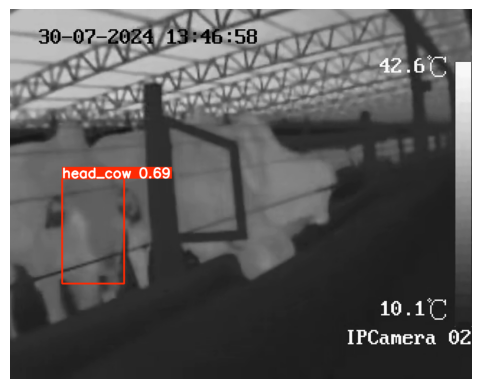

In [20]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time  # Importa o m√≥dulo time para medir o tempo

# Carrego seu modelo treinado
model = YOLO('/content/runs/detect/detect_head_cow/weights/best.pt')

# Carrego a imagem para teste
image_path = '/content/frame_0008.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converto BGR para RGB

# Medir o tempo de infer√™ncia
start_time = time.time()  # Marca o tempo antes da predi√ß√£o

# Realizo a predi√ß√£o
results = model.predict(image)

# Marca o tempo ap√≥s a predi√ß√£o
inference_time = time.time() - start_time
print(f"Tempo de Infer√™ncia: {inference_time:.4f} segundos")

# Exiba os resultados
for result in results:
    # Mostro a imagem com as predi√ß√µes
    plt.imshow(result.plot())  # Ploto a imagem com caixas delimitadoras
    plt.axis('off')
    plt.show()


## Vizualiza√ß√£o das masc√°ras

Nesta c√©lula, as primeiras cinco imagens e suas m√°scaras processadas s√£o exibidas lado a lado. Para cada imagem no conjunto X_data, uma figura √© criada com duas subplots: a primeira exibe a imagem original, e a segunda mostra a m√°scara bin√°ria correspondente, que representa a √°rea do olho, usando uma escala de cinza. Esse processo visualiza e valida o pr√©-processamento realizado nas m√°scaras.

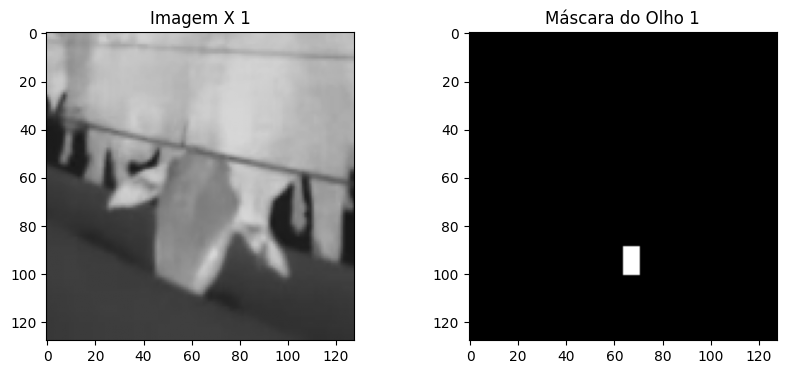

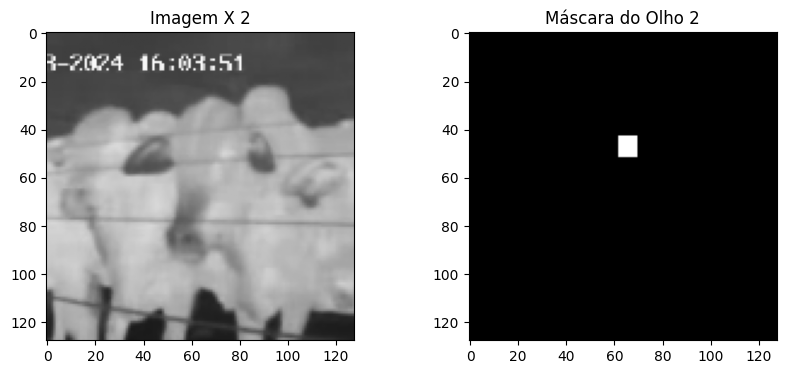

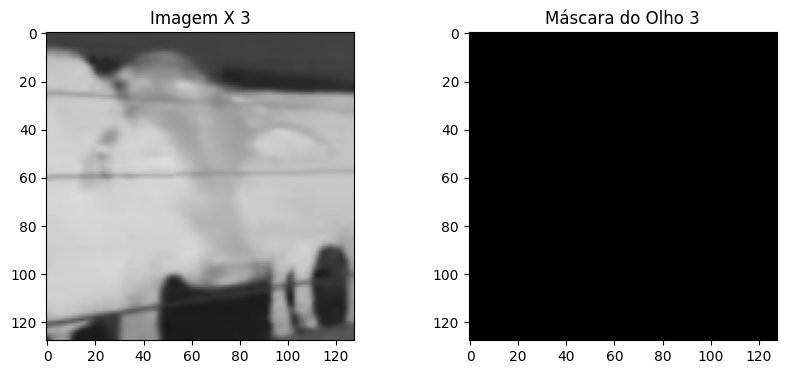

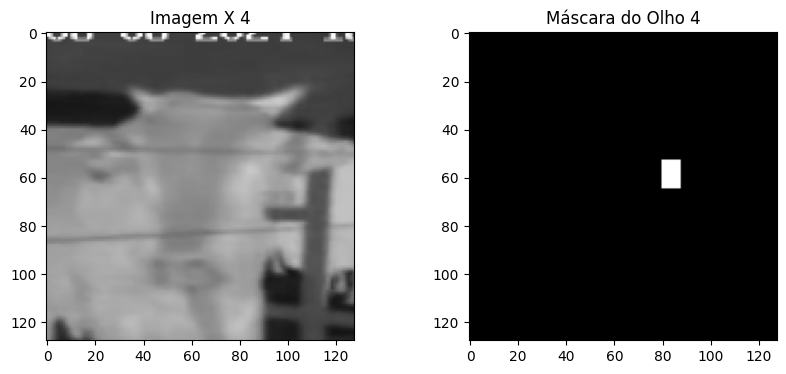

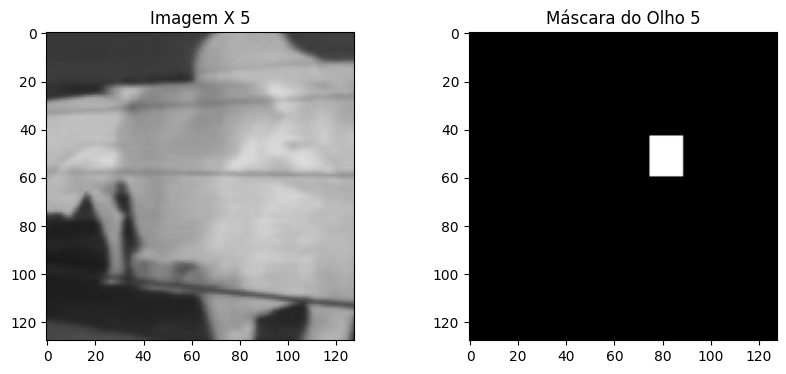

In [ ]:
for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))

    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')

    # Plotando a m√°scara Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data_processed[i], cmap='gray')
    plt.title(f'M√°scara do Olho {i+1}')

    plt.show()

## Separa√ß√£o em 2 tipos de arquitetura CNN para a U-Net

- Arquitetura com Tecnicas contra overfitting
  - Reguraliza√ß√£o
  - Dropout
  - Early stopping

- Arquitetura "original"



### Fun√ß√£o conv_block

Essa fun√ß√£o, chamada conv_block, implementa um bloco de convolu√ß√£o padr√£o utilizado em redes neurais convolucionais. Ela recebe dois par√¢metros: inputs, que √© a entrada para o bloco, e filterCount, que define o n√∫mero de filtros nas camadas convolucionais.

O bloco consiste em duas camadas convolucionais seguidas de normaliza√ß√£o em batch (BatchNormalization), que ajuda a estabilizar e acelerar o treinamento, e uma fun√ß√£o de ativa√ß√£o ReLU, que introduz n√£o linearidade. Ambas as convolu√ß√µes utilizam filtros 3x3 com padding "same", o que mant√©m as dimens√µes espaciais da entrada. Esse bloco √© uma constru√ß√£o b√°sica para extrair caracter√≠sticas das imagens de entrada.

No final, a sa√≠da x, ap√≥s as duas opera√ß√µes convolucionais e ativa√ß√µes, √© retornada para ser usada nas camadas subsequentes da rede.

In [ ]:
def conv_block(inputs,filterCount):
    x = Conv2D(filterCount,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    x = Conv2D(filterCount,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

### Fun√ß√£o conv_block_nor
Essa fun√ß√£o, chamada conv_block_nor, implementa um bloco convolucional com regulariza√ß√£o L2 e dropout, al√©m da normaliza√ß√£o em batch e a ativa√ß√£o ReLU.

Ela recebe dois par√¢metros: inputs, que s√£o os dados de entrada, e filter_count, que define a quantidade de filtros nas camadas convolucionais. O bloco realiza o seguinte:

Aplica uma camada convolucional com filtros 3x3, onde √© adicionada regulariza√ß√£o L2 para evitar overfitting.
Utiliza a normaliza√ß√£o em batch para estabilizar o treinamento.
Aplica a fun√ß√£o de ativa√ß√£o ReLU, que adiciona n√£o linearidade.
Aplica dropout com uma taxa de 0.6 para reduzir overfitting, desativando aleatoriamente 60% dos neur√¥nios durante o treinamento.
Esses passos s√£o repetidos duas vezes, retornando a sa√≠da final, que ser√° usada nas camadas seguintes da rede. Esse bloco combina regulariza√ß√£o e dropout para melhorar a robustez do modelo.

In [ ]:

def conv_block_nor(inputs, filter_count):
    x = Conv2D(filter_count, 3, padding="same", kernel_regularizer=l2(1e-4))(inputs)  # Regulariza√ß√£o L2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.6)(x)  # Dropout de 0.6

    x = Conv2D(filter_count, 3, padding="same", kernel_regularizer=l2(1e-4))(x)  # Regulariza√ß√£o L2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.6)(x)  # Dropout de 0.6
    return x

### Fun√ß√£o decoder_block

A fun√ß√£o decoder_block √© respons√°vel por realizar a decodifica√ß√£o na rede, especialmente em arquiteturas como a U-Net, onde a ideia √© recuperar as dimens√µes originais da imagem ao longo do caminho de sa√≠da. Ela recebe tr√™s par√¢metros: inputs, que s√£o os dados da camada anterior; skip_features, que correspondem √†s conex√µes de atalho (skip connections) da fase de codifica√ß√£o; e filter_count, que define a quantidade de filtros para as camadas convolucionais.

Primeiramente, a fun√ß√£o utiliza a camada Conv2DTranspose, que √© uma convolu√ß√£o transposta, para aumentar a resolu√ß√£o espacial das entradas, realizando um upsampling, ou seja, dobrando a resolu√ß√£o da imagem. Em seguida, os resultados da convolu√ß√£o transposta s√£o concatenados com as skip_features da parte correspondente do encoder. Essa concatena√ß√£o permite que detalhes perdidos durante a redu√ß√£o de dimensionalidade sejam recuperados, utilizando informa√ß√µes detalhadas armazenadas na fase de codifica√ß√£o.

Por fim, o bloco convolucional conv_block √© chamado para processar o resultado combinado, aplicando duas camadas convolucionais que refinam a informa√ß√£o e preparam a sa√≠da final do bloco. O objetivo desse bloco √©, portanto, restaurar a resolu√ß√£o da imagem ao mesmo tempo em que aproveita as informa√ß√µes detalhadas da fase de codifica√ß√£o para melhorar a precis√£o da segmenta√ß√£o.

In [ ]:
def decoder_block(inputs,skip_features,filter_count):

    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

### Fun√ß√£o decoder_block_nor

A fun√ß√£o decoder_block_nor √© uma vers√£o modificada de um bloco de decodifica√ß√£o que incorpora regulariza√ß√£o e dropout durante o processo de reconstru√ß√£o da imagem. Ela recebe tr√™s par√¢metros: inputs, que s√£o as sa√≠das da camada anterior; skip_features, que s√£o as conex√µes de atalho da fase de codifica√ß√£o; e filter_count, que define o n√∫mero de filtros a serem aplicados nas camadas convolucionais.

Primeiro, a fun√ß√£o aplica uma convolu√ß√£o transposta (Conv2DTranspose) para aumentar a resolu√ß√£o espacial da entrada, dobrando as dimens√µes da imagem. Isso ajuda a reverter a redu√ß√£o de dimensionalidade que ocorre durante a fase de codifica√ß√£o. Em seguida, as sa√≠das dessa camada s√£o concatenadas (Concatenate) com as skip_features, que trazem informa√ß√µes detalhadas da parte de codifica√ß√£o para melhorar a reconstru√ß√£o dos detalhes finos da imagem.

Depois de concatenar, o c√≥digo chama a fun√ß√£o conv_block_nor, que aplica dois blocos convolucionais com regulariza√ß√£o L2 e dropout. Isso √© feito para melhorar a generaliza√ß√£o do modelo e evitar overfitting, al√©m de estabilizar o treinamento. Ao final, a sa√≠da resultante √© retornada, j√° processada e com a resolu√ß√£o restaurada, mantendo as informa√ß√µes detalhadas vindas da fase de codifica√ß√£o.

In [ ]:
def decoder_block_nor(inputs,skip_features,filter_count):

    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block_nor(x, filter_count)
    return x

### Fun√ß√£o unet_vgg16
A fun√ß√£o unet_vgg16 implementa uma arquitetura U-Net utilizando o modelo pr√©-treinado VGG16 como o encoder, aproveitando as camadas convolucionais desse modelo para extra√ß√£o de caracter√≠sticas.

O modelo come√ßa com as entradas definidas pelo par√¢metro input_shape. O VGG16 √© carregado sem a camada de classifica√ß√£o final (include_top=False) e com pesos pr√©-treinados na ImageNet. As sa√≠das intermedi√°rias de v√°rias camadas do VGG16, chamadas skip1 a skip4, s√£o armazenadas para serem reutilizadas no processo de decodifica√ß√£o (essas s√£o as "skip connections" que ajudam a preservar detalhes da imagem).

A partir da camada central (extra√≠da da √∫ltima camada convolucional do VGG16), o modelo come√ßa a fase de decodifica√ß√£o, onde as dimens√µes espaciais s√£o gradualmente restauradas atrav√©s de blocos de decodifica√ß√£o (decoder_block), usando as informa√ß√µes das skip connections. O processo de decodifica√ß√£o √© aplicado em quatro n√≠veis, cada um restaurando uma parte da resolu√ß√£o da imagem.

No final, uma camada convolucional com um filtro de tamanho 1x1 e ativa√ß√£o "sigmoid" gera a sa√≠da da U-Net, que tem um √∫nico canal, representando uma m√°scara bin√°ria para segmenta√ß√£o.

Esse modelo √© projetado para segmentar objetos em imagens aproveitando a arquitetura profunda do VGG16 para a extra√ß√£o de caracter√≠sticas e a estrutura U-Net para a reconstru√ß√£o da m√°scara de segmenta√ß√£o.


In [ ]:
def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)

    # Encoder
    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output

    # Centro
    center = vgg16.get_layer("block5_conv3").output

    # Decoder
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    # Sa√≠da com 1 canal (m√°scara bin√°ria)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

### Fun√ß√£o unet_vgg16_nor

A fun√ß√£o unet_vgg16_nor √© uma varia√ß√£o do modelo U-Net que utiliza o VGG16 como encoder, por√©m com regulariza√ß√£o L2 e dropout aplicados nas camadas do decodificador, atrav√©s do uso da fun√ß√£o decoder_block_nor.

Assim como na vers√£o anterior, o modelo come√ßa carregando o VGG16 sem a camada final de classifica√ß√£o (include_top=False), utilizando os pesos pr√©-treinados na ImageNet. As sa√≠das de camadas intermedi√°rias (skip1 a skip4) s√£o armazenadas para uso no decodificador.

Na fase de decodifica√ß√£o, ao inv√©s de usar o decoder_block simples, o c√≥digo usa decoder_block_nor, que inclui regulariza√ß√£o L2 e dropout, o que ajuda a melhorar a generaliza√ß√£o do modelo e a mitigar o overfitting. Esse processo √© feito em quatro n√≠veis de decodifica√ß√£o, restaurando as dimens√µes da imagem enquanto incorpora informa√ß√µes detalhadas do encoder.

No final, a sa√≠da √© uma m√°scara bin√°ria gerada por uma camada convolucional com um √∫nico filtro 1x1 e ativa√ß√£o "sigmoid", representando a √°rea segmentada da imagem.

Essa vers√£o do modelo √© mais robusta contra overfitting, gra√ßas √† inclus√£o de t√©cnicas de regulariza√ß√£o durante o processo de decodifica√ß√£o.

In [ ]:
def unet_vgg16_nor(input_shape):
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)

    # Encoder
    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output

    # Centro
    center = vgg16.get_layer("block5_conv3").output

    # Decoder
    d1 = decoder_block_nor(center,skip4,512)
    d2 = decoder_block_nor(d1,skip3,256)
    d3 = decoder_block_nor(d2,skip2,128)
    d4 = decoder_block_nor(d3,skip1,64)

    # Sa√≠da com 1 canal (m√°scara bin√°ria)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

### input_shape e declara√ß√£o das arquiteturas dos modelos

Aqui, duas inst√¢ncias de modelos U-Net com base no VGG16 s√£o criadas, ambos com uma entrada de imagens de formato (128, 128, 3) (imagens RGB de 128x128 pixels).

O primeiro modelo, model, √© gerado pela fun√ß√£o unet_vgg16(input_shape), que utiliza a vers√£o padr√£o do U-Net com VGG16 como encoder, sem regulariza√ß√£o adicional no decodificador.

O segundo modelo, model2, √© criado pela fun√ß√£o unet_vgg16_nor(input_shape), que aplica regulariza√ß√£o L2 e dropout nos blocos de decodifica√ß√£o, tornando-o mais robusto contra overfitting.

Ambos os modelos est√£o prontos para serem treinados em tarefas de segmenta√ß√£o, sendo o model2 mais adequado para cen√°rios onde o risco de overfitting √© maior.

In [ ]:
input_shape = (128,128,3)
model = unet_vgg16(input_shape)
model2 = unet_vgg16_nor(input_shape)

58889256/58889256 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 0us/step


### Fun√ß√£o de perda

Esse c√≥digo define a fun√ß√£o de perda Dice Loss, que √© frequentemente usada em tarefas de segmenta√ß√£o, especialmente quando se trabalha com dados que possuem desequil√≠brio de classes. A fun√ß√£o mede a sobreposi√ß√£o entre as previs√µes do modelo (y_pred) e os valores reais (y_true), ajudando a maximizar a precis√£o da segmenta√ß√£o de regi√µes espec√≠ficas.

In [ ]:

# Define the Dice Loss function
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice


### Compila√ß√£o e Treinamento do modelo

Aqui o modelo U-Net √© compilado e treinado para a tarefa de segmenta√ß√£o.

Compila√ß√£o do Modelo: O modelo √© compilado utilizando o otimizador Adam com uma taxa de aprendizado definida como 1e-3. A fun√ß√£o de perda usada √© a Dice Loss, que √© ideal para tarefas de segmenta√ß√£o, e a m√©trica utilizada para monitoramento √© a acur√°cia ("accuracy"). A Dice Loss ajuda a avaliar a sobreposi√ß√£o entre as previs√µes do modelo e as m√°scaras reais.

Treinamento do Modelo: O modelo √© treinado utilizando o conjunto de dados de treino (X_train e Y_train) com 50 √©pocas. O par√¢metro steps_per_epoch define quantos lotes (batches) de 32 imagens s√£o processados por √©poca. A valida√ß√£o √© feita ao final de cada √©poca utilizando o conjunto de valida√ß√£o (X_val e Y_val), o que permite monitorar a performance do modelo ao longo do treinamento.

Avalia√ß√£o do Modelo: Ap√≥s o treinamento, o modelo √© avaliado no conjunto de valida√ß√£o usando a fun√ß√£o model.evaluate. Isso fornece uma vis√£o geral de qu√£o bem o modelo generaliza, calculando a perda (Dice Loss) e a acur√°cia no conjunto de valida√ß√£o.

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=["accuracy"])


# Treinando o modelo
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    )
# Avalia√ß√£o do modelo
model.evaluate(X_val, Y_val)

Epoch 1/50
59/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 315ms/step - accuracy: 0.7212 - loss: 0.9214

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 55s 421ms/step - accuracy: 0.7234 - loss: 0.9204 - val_accuracy: 0.0213 - val_loss: 0.9771
Epoch 2/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 58ms/step - accuracy: 0.9818 - loss: 0.6546 - val_accuracy: 0.6991 - val_loss: 0.9439
Epoch 3/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 58ms/step - accuracy: 0.9867 - loss: 0.5376 - val_accuracy: 0.9176 - val_loss: 0.8331
Epoch 4/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 58ms/step - accuracy: 0.9876 - loss: 0.5100 - val_accuracy: 0.8716 - val_loss: 0.8756
Epoch 5/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 58ms/step - accuracy: 0.9879 - loss: 0.4954 - val_accuracy: 0.9895 - val_loss: 0.5441
Epoch 6/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 58ms/step - accuracy: 0.9883 - loss: 0.4812 - val_accuracy: 0.9837 - val_loss: 0.6243
Epoch 7

[0.47824981808662415, 0.9907448291778564]

### Utiliza√ß√£o de data augmentation
Neste c√≥digo, o Data Augmentation √© configurado para aumentar a diversidade dos dados de treino, aplicando transforma√ß√µes como rota√ß√µes, deslocamentos, zoom, flips horizontais, e cisalhamento nas imagens. Essas t√©cnicas ajudam a prevenir overfitting ao gerar varia√ß√µes nas imagens de cada batch de treino, sem aumentar o tamanho do dataset. Para o conjunto de valida√ß√£o, as imagens s√£o geradas sem qualquer altera√ß√£o. Dois geradores, um para o treino e outro para a valida√ß√£o, s√£o configurados para fornecer batches de 32 imagens e suas respectivas m√°scaras durante o treinamento.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Definindo um Data Augmentation
data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     shear_range=0.2,
                     fill_mode='nearest')

# Aumentar a diversidade dos dados pode ajudar a prevenir overfitting
train_datagen = ImageDataGenerator(**data_gen_args)

# Gera dados para o conjunto de valida√ß√£o, sem aplicar Data Augmentation.
val_datagen = ImageDataGenerator()

# Gera batches de imagens e m√°scaras para o treino, com augmenta√ß√£o aplicada.
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)

# Gera batches de imagens e m√°scaras para a valida√ß√£o, sem augmenta√ß√£o.
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)

### Compilando segundo modelo e treinando

Neste c√≥digo, o segundo modelo U-Net (model2) √© compilado com uma taxa de aprendizado inicial menor (1e-4), visando ajustes mais finos durante o treinamento. A fun√ß√£o de perda usada √© a Dice Loss, e a m√©trica monitorada √© a acur√°cia.

Foram definidos dois callbacks para melhorar a efici√™ncia do treinamento:

EarlyStopping com paci√™ncia reduzida para 10 √©pocas sem melhora, para evitar que o modelo continue treinando desnecessariamente, al√©m de restaurar os melhores pesos.
ReduceLROnPlateau, que monitora a perda de valida√ß√£o e reduz a taxa de aprendizado em 10 vezes (fator de 0.1) se a perda n√£o melhorar ap√≥s 5 √©pocas consecutivas, evitando overfitting e permitindo ajustes mais finos nos √∫ltimos est√°gios do treinamento.
O modelo √© treinado usando o gerador de dados com 50 √©pocas, e os callbacks garantem que o treinamento seja ajustado conforme o progresso. Ap√≥s o treinamento, o modelo √© avaliado no conjunto de valida√ß√£o para medir o desempenho final.

In [ ]:

# Compilando o modelo com uma taxa de aprendizado inicial menor
model2.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

# Callbacks ajustados
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),  # Reduzindo patience para 5
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),  # Fator de redu√ß√£o mais agressivo
]

# Treinando o modelo com o gerador de dados
history2 = model2.fit(train_generator,
                      validation_data=val_generator,
                      steps_per_epoch=len(X_train) // 32,
                      epochs=50,
                      callbacks=callbacks)

# Avalia√ß√£o do modelo
model2.evaluate(X_val, Y_val)

Epoch 1/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 320ms/step - accuracy: 0.9381 - loss: 0.8813 - val_accuracy: 0.9219 - val_loss: 0.8946 - learning_rate: 1.0000e-04
Epoch 2/50
 1/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 57ms/step - accuracy: 0.9369 - loss: 0.8559

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - accuracy: 0.9369 - loss: 0.8559 - val_accuracy: 0.9266 - val_loss: 0.8917 - learning_rate: 1.0000e-04
Epoch 3/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 117ms/step - accuracy: 0.9419 - loss: 0.8750 - val_accuracy: 0.9824 - val_loss: 0.8732 - learning_rate: 1.0000e-04
Epoch 4/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - accuracy: 0.9471 - loss: 0.8286 - val_accuracy: 0.9872 - val_loss: 0.9419 - learning_rate: 1.0000e-04
Epoch 5/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 116ms/step - accuracy: 0.9426 - loss: 0.8687 - val_accuracy: 0.9601 - val_loss: 0.8605 - learning_rate: 1.0000e-04
Epoch 6/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - accuracy: 0.9510 - loss: 0.8215 - val_accuracy: 0.9579 - val_loss: 0.8698 - learning_rate: 1.0000e-04
Epoch 7/50
60/60 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

[0.7903949618339539, 0.9557967782020569]

## Visualiza√ß√£o e compara√ß√£o dos dois modelos


Esta fun√ß√£o compara visualmente as segmenta√ß√µes geradas por dois modelos diferentes para uma mesma imagem. Ela exibe a imagem original, a m√°scara verdadeira, e as predi√ß√µes feitas por ambos os modelos, permitindo avaliar visualmente as diferen√ßas no desempenho entre eles.

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 751ms/step


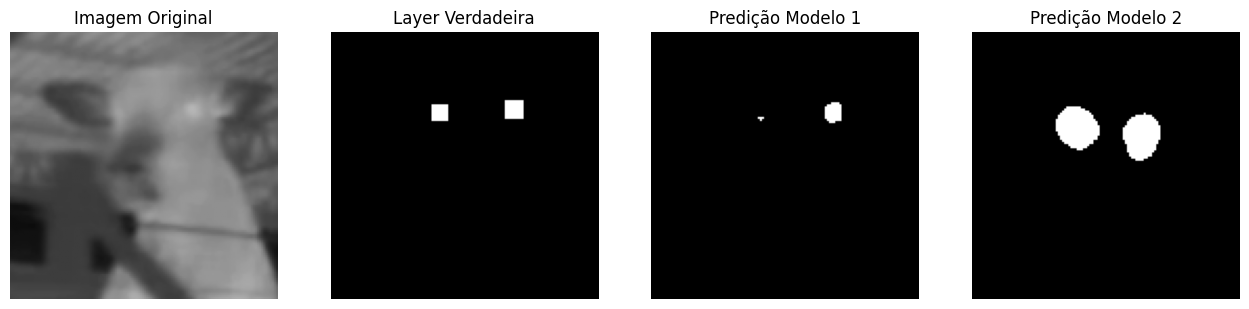

In [ ]:

# Exibindo a compara√ß√£o das segmenta√ß√µes de uma imagem entre dois modelos
def plot_prediction_comparison(model1, model2, X, Y, index):

    # Predi√ß√£o com o primeiro modelo
    pred1 = model1.predict(np.expand_dims(X[index], axis=0))
    pred1 = (pred1 > 0.5).astype(np.uint8)  # Binarizando a predi√ß√£o

    # Predi√ß√£o com o segundo modelo
    pred2 = model2.predict(np.expand_dims(X[index], axis=0))
    pred2 = (pred2 > 0.5).astype(np.uint8)  # Binarizando a predi√ß√£o

    plt.figure(figsize=(20, 5))

    # Imagem Original
    plt.subplot(1, 5, 1)
    plt.imshow(X[index])
    plt.title('Imagem Original')
    plt.axis('off')

    # Layer Verdadeira
    plt.subplot(1, 5, 2)
    plt.imshow(np.squeeze(Y[index]), cmap='gray')
    plt.title('Layer Verdadeira')
    plt.axis('off')

    # Predi√ß√£o Modelo 1
    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(pred1), cmap='gray')
    plt.title('Predi√ß√£o Modelo 1')
    plt.axis('off')

    # Predi√ß√£o Modelo 2
    plt.subplot(1, 5, 4)
    plt.imshow(np.squeeze(pred2), cmap='gray')
    plt.title('Predi√ß√£o Modelo 2')
    plt.axis('off')


    plt.show()

# Exemplo de predi√ß√£o
plot_prediction_comparison(model, model2, X_val, Y_val, index=10)

## Demonstra√ß√£o dos resultados:

Nesta c√©lula, comparamos os resultados de dois modelos: o "modelo original" e o "modelo com t√©cnicas de combate ao overfitting". Ambos os modelos s√£o visualizados atrav√©s de gr√°ficos de acur√°cia e perda ao longo das √©pocas de treinamento e valida√ß√£o.

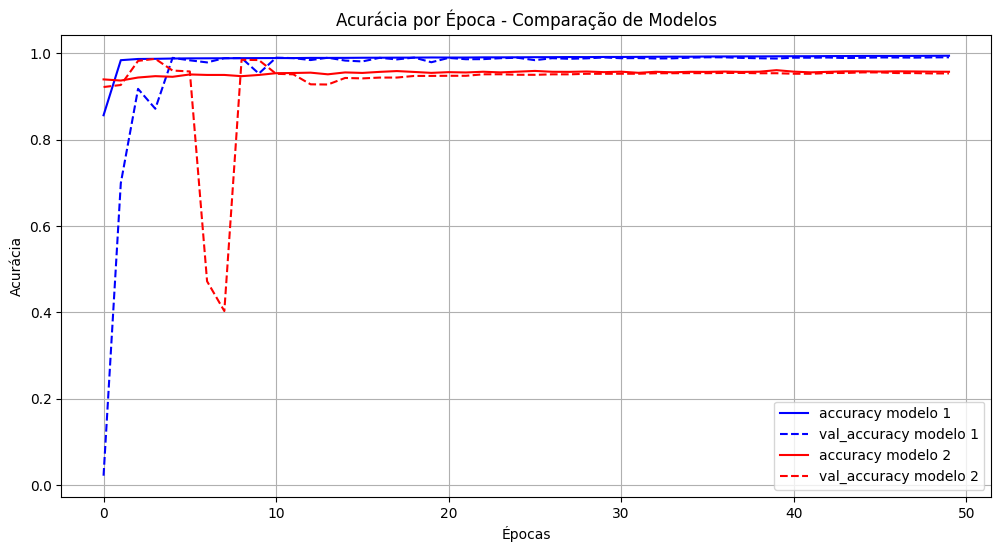

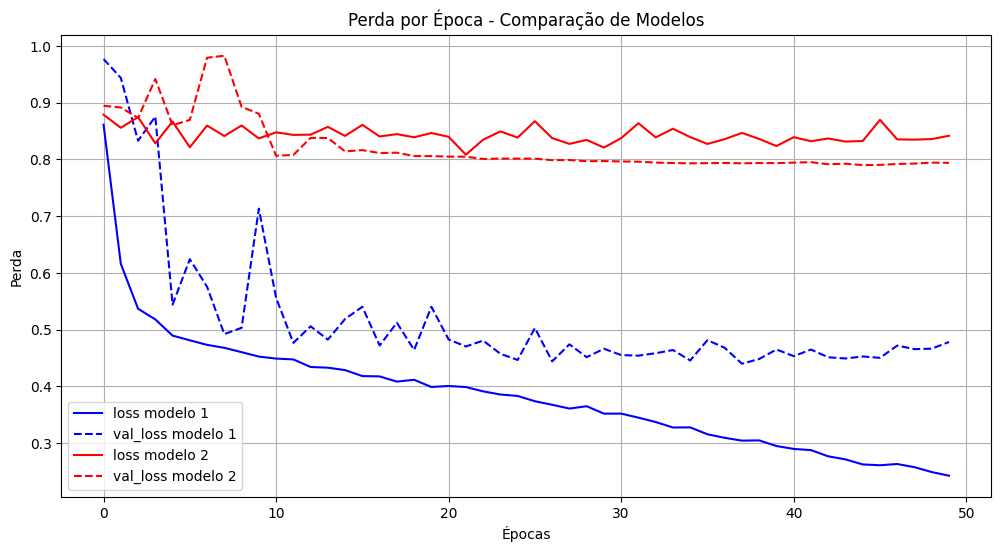

In [ ]:

# Fun√ß√£o para plotar os gr√°ficos de acur√°cia e perda de dois modelos
def plot_accuracy_loss(history1, history2):

    # Gr√°fico de Acur√°cia
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history['accuracy'], label='accuracy modelo 1', color='blue')
    plt.plot(history1.history['val_accuracy'], label='val_accuracy modelo 1', color='blue', linestyle='dashed')
    plt.plot(history2.history['accuracy'], label='accuracy modelo 2', color='red')
    plt.plot(history2.history['val_accuracy'], label='val_accuracy modelo 2', color='red', linestyle='dashed')
    plt.xlabel('√âpocas')
    plt.ylabel('Acur√°cia')
    plt.title('Acur√°cia por √âpoca - Compara√ß√£o de Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gr√°fico de Perda
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history['loss'], label='loss modelo 1', color='blue')
    plt.plot(history1.history['val_loss'], label='val_loss modelo 1', color='blue', linestyle='dashed')
    plt.plot(history2.history['loss'], label='loss modelo 2', color='red')
    plt.plot(history2.history['val_loss'], label='val_loss modelo 2', color='red', linestyle='dashed')
    plt.xlabel('√âpocas')
    plt.ylabel('Perda')
    plt.title('Perda por √âpoca - Compara√ß√£o de Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy_loss(history, history2)



### Fun√ß√£o de perda do primeiro modelo / treinamento e valida√ß√£o

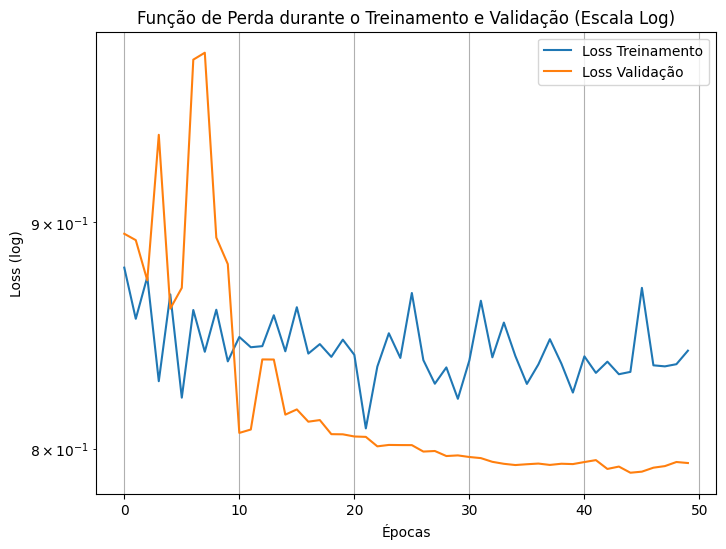

In [ ]:
# Fun√ß√£o para plotar o gr√°fico de perda (loss)
def plot_loss(history):
    plt.figure(figsize=(8, 6))

    # Plotando a perda no treinamento
    plt.plot(history.history['loss'], label='Loss Treinamento')

    # Plotando a perda na valida√ß√£o
    plt.plot(history.history['val_loss'], label='Loss Valida√ß√£o')

    # Configura√ß√µes do gr√°fico
    plt.title('Fun√ß√£o de Perda durante o Treinamento e Valida√ß√£o (Escala Log)')
    plt.xlabel('√âpocas')
    plt.ylabel('Loss (log)')
    plt.yscale('log')  # Definir o eixo y como logar√≠tmico
    plt.legend(loc='upper right')
    plt.grid(True)

    # Mostrando o gr√°fico
    plt.show()

# Gerando o gr√°fico de perda
plot_loss(history2)


### Fun√ß√£o para plotar imagem original, m√°scara real e previs√£o do primeiro modelo

### Visualiza√ß√£o da M√°scara de Segmenta√ß√£o Predita Sobreposta √† Imagem Original com Transpar√™ncia

Este c√≥digo define uma fun√ß√£o que sobrep√µe uma m√°scara de segmenta√ß√£o predita sobre uma imagem original, utilizando transpar√™ncia para destacar as √°reas segmentadas. A fun√ß√£o, chamada overlay_mask_on_image, recebe como par√¢metros a imagem original, a m√°scara predita bin√°ria e um valor de transpar√™ncia (alpha). A m√°scara √© redimensionada para ter tr√™s canais (RGB) e aplicada na imagem original, com as √°reas segmentadas destacadas em vermelho. A imagem resultante √© uma combina√ß√£o da imagem original e da m√°scara predita com transpar√™ncia, facilitando a visualiza√ß√£o do desempenho do modelo.

Ap√≥s a defini√ß√£o da fun√ß√£o, o c√≥digo gera previs√µes de m√°scara sobre o conjunto de valida√ß√£o e, para cada imagem em um intervalo de 10 imagens, aplica a fun√ß√£o de sobreposi√ß√£o, exibindo o resultado final.

16/16 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step


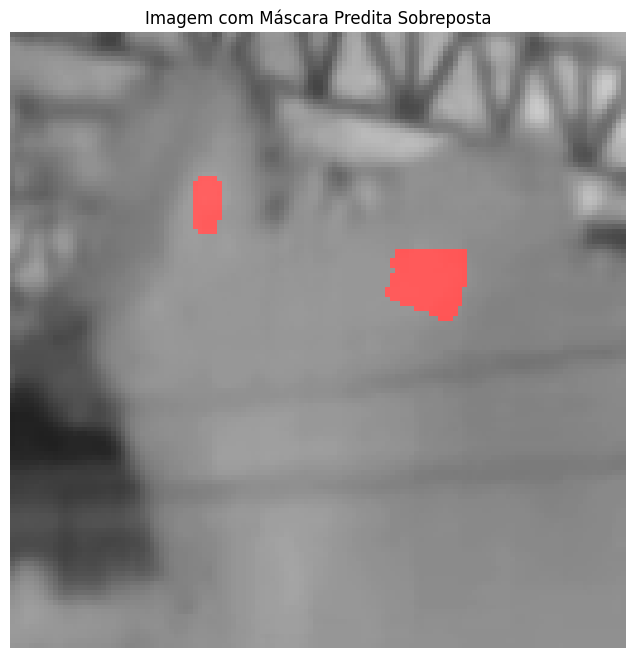

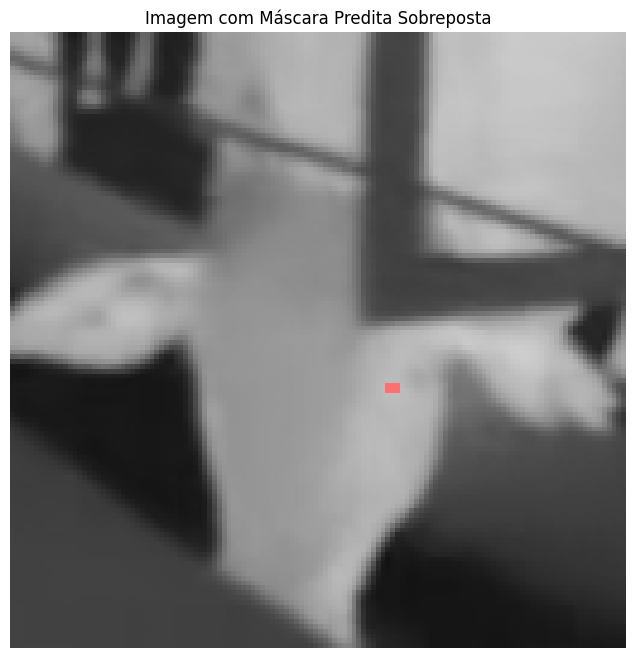

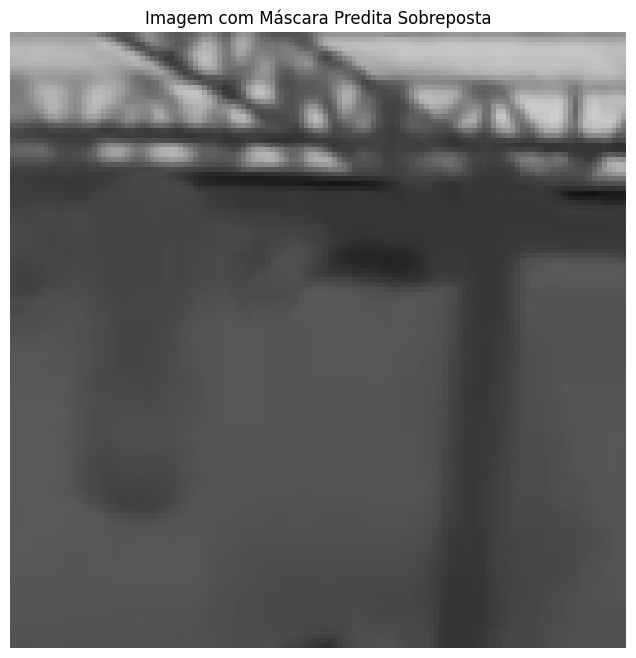

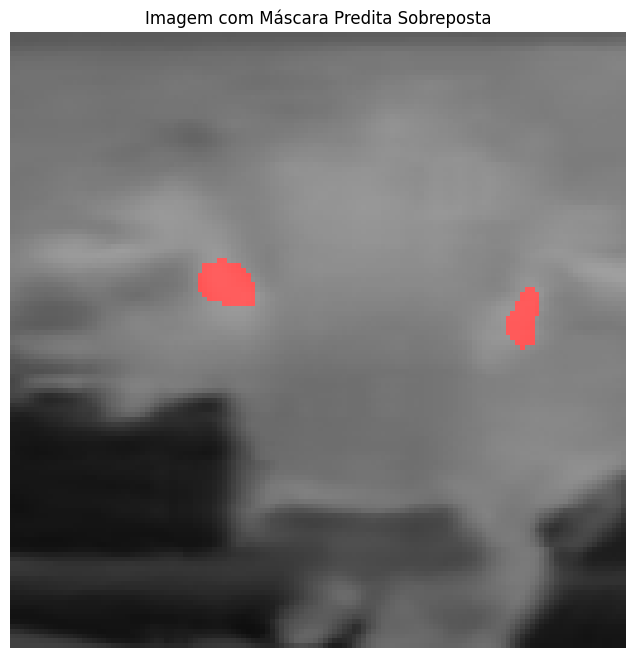

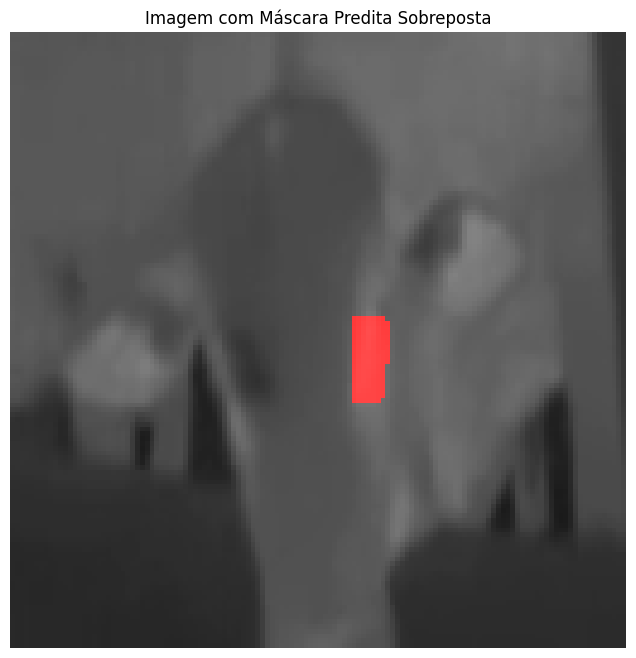

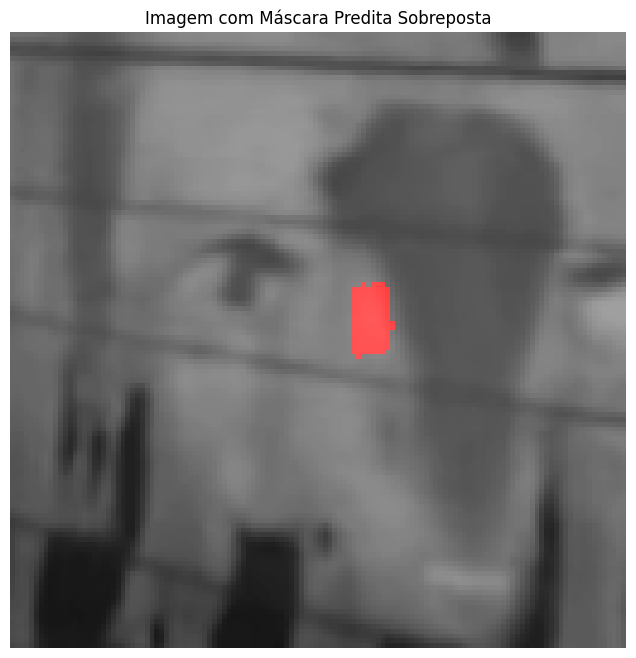

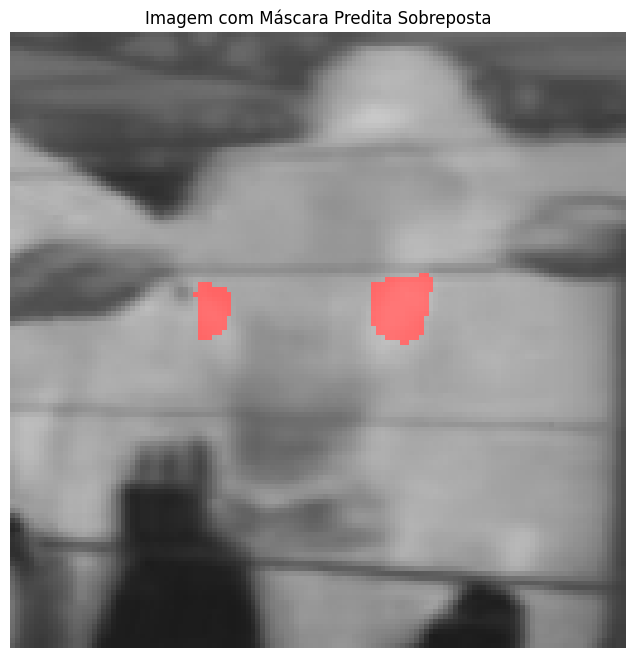

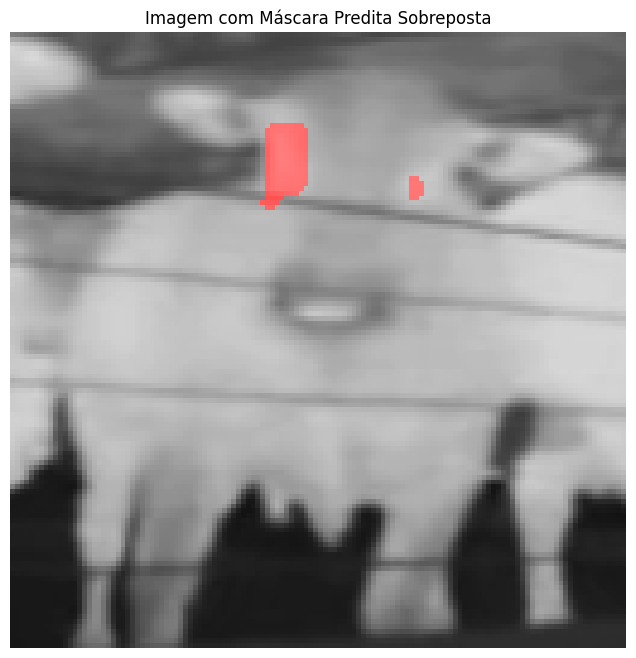

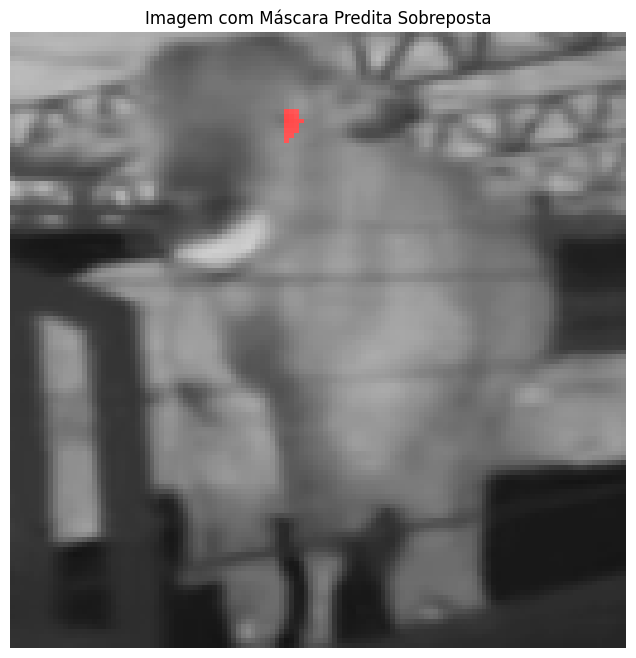

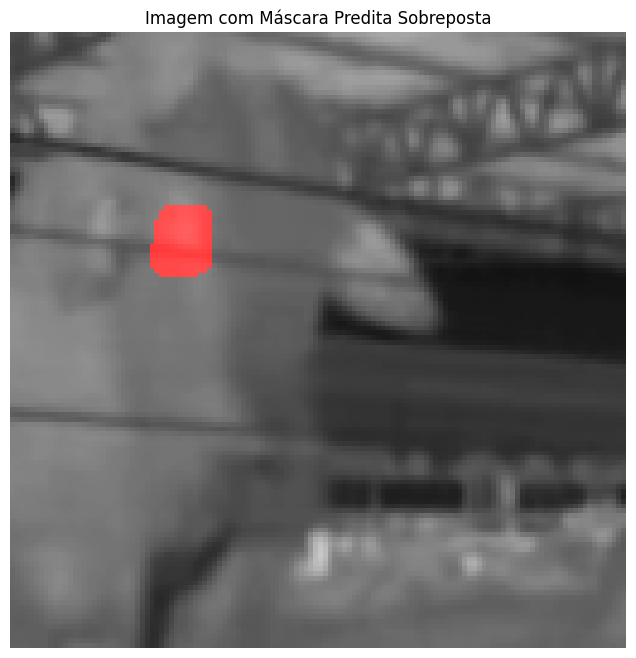

In [ ]:

def overlay_mask_on_image(image, mask, alpha=0.4):
    """
    Sobrep√µe a m√°scara predita sobre a imagem original com transpar√™ncia.
    """
    # Garantir que a m√°scara esteja no formato (128, 128, 1)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    # Redimensionar a m√°scara para ter 3 canais (RGB)
    mask_rgb = np.concatenate([mask, mask, mask], axis=-1)

    # Criar uma imagem vermelha do tamanho da m√°scara
    red_mask = np.zeros_like(image, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # Canal vermelho (R) √© 255, os outros s√£o 0

    # Aplicar a m√°scara vermelha nas √°reas onde a m√°scara predita √© branca (valor 1)
    overlay = np.where(mask_rgb == 1, red_mask, image)

    # Misturar a imagem original e a m√°scara sobreposta usando alpha para transpar√™ncia
    output = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    return output

# Gerar predi√ß√µes no conjunto de valida√ß√£o
y_pred = model.predict(X_val)

for i in range(30,40):
  # Supondo que X_val[0] seja a imagem original e y_pred[0] seja a m√°scara predita
  image = X_val[i]  # A imagem original
  mask = (y_pred[i] > 0.5).astype(np.uint8)  # Converter a m√°scara predita para bin√°ria (0 ou 1)

  # Chamar a fun√ß√£o para sobrepor a m√°scara
  overlay_result = overlay_mask_on_image(image, mask)

  # Exibir a imagem com a m√°scara sobreposta
  plt.figure(figsize=(8, 8))
  plt.imshow(overlay_result)
  plt.title('Imagem com M√°scara Predita Sobreposta')
  plt.axis('off')
  plt.show()


### Medi√ß√£o de Tempo de Treinamento, Infer√™ncia e C√°lculo de M√©tricas de Precis√£o, Recall e F1-score

Este c√≥digo mede o tempo total de treinamento do modelo e o tempo m√©dio de infer√™ncia por imagem no conjunto de valida√ß√£o. Al√©m disso, ele calcula as m√©tricas de avalia√ß√£o: precis√£o, recall e F1-score. Essas m√©tricas comparam as previs√µes do modelo com as m√°scaras reais do conjunto de valida√ß√£o, avaliando a qualidade do modelo na tarefa de segmenta√ß√£o. O tempo de treinamento √© medido com um cron√¥metro, enquanto o tempo de infer√™ncia √© calculado para cada imagem individualmente. Por fim, o c√≥digo converte as previs√µes e os r√≥tulos em bin√°rio para calcular as m√©tricas de desempenho.



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Medir o tempo de treinamento
start_time = time.time()

training_time = time.time() - start_time
training_hours, training_minutes = divmod(training_time // 60, 60)
print(f"Tempo Total de Treinamento: {int(training_hours)} horas e {int(training_minutes)} minutos")

# Medir o tempo de infer√™ncia por imagem
start_time = time.time()
predictions = np.array([model.predict(np.expand_dims(img, axis=0)) for img in X_val])
inference_time = (time.time() - start_time) / len(X_val)
print(f"Tempo M√©dio de Infer√™ncia por Imagem: {inference_time:.4f} segundos")

# Calcular precis√£o, recall e F1-score
Y_val_binary = (Y_val > 0.5).astype(np.uint8)
predictions_binary = (predictions > 0.5).astype(np.uint8)

# Achando precis√£o, recall e F1-score para cada imagem
precision = precision_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
recall = recall_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
f1 = f1_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')

print(f"Precis√£o: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Tempo Total de Treinamento: 0 horas e 0 minutos
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ

Salvando o modelo de segmenta√ß√£o

In [ ]:
model2.save('/content/drive/MyDrive/data/saved_model/modelo_segmentacao.keras')